# Decision Making Under Uncertainty - Assignment 1

Group 2:
- Martijn Ketelaars (ANR: 120975)
- Robbie Reyerse (ANR: 109997)
- Rosalien Timmerhuis (ANR: 520618)
- Mike Weltevrede (ANR: 756479)

This assignment is about the Stochastic Knapsack Problem (SKP). In the general SKP you are choosing a subset among $N$ items $(i= 1,....,N)$ to allocate to a knapsack of capacity $K$. Each item $i$ has a random size of $w_i$ units. We assume that item sizes are statistically independent. If the collective size of the selected items exceeds the capacity, a penalty of $p$ is assessed per unit excess. We assume that item $i$ has an associated per-unit revenue $r_i$ with $r_i < p$. Different objective functions are possible, i.e. maximizing the profit.

The binary decision variable $x_i$ takes a value of $1$ if item $i$ is allocated to the knapsack and a value of $0$ otherwise. All items are considered simultaneously and the values of their sizes are unknown before selection decisions are made. In this assignment, the item size $w_i$ can take only two values, namely $d\_h_i$ and $d\_l_i$, with probabilities $P(w_i = d\_h_i ) = \pi_i$ and $P(w_i = d\_l_i ) = 1-\pi_i$.

We start by initialising our problem by importing the necessary Python libraries and setting the parameters that are set in stone, namely the number of instances, the number of items $N$, and the variable $g$ (our group number). We also set the parameters $\alpha$ and $\beta$, which are needed in our model to signify the extent of risky behaviour.

In [1]:
import random
import math
import itertools
import re

import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gb
from scipy import stats

In [2]:
# Set parameters
num_instances = 10
num_items = 10
g = 2 # group number
alpha_model = {"EV": 0, "CVaR": 0.95}
beta_model = {"EV": 0, "CVaR": 1}

# Generation of Problem Instances
## Part 1
In the first part, we want to generate 10 random instances of the Stochastic Knapsack Problem (SKP). For this, we need to generate values for the low weights $d\_l_i$ using the Poisson distribution. From Lab 2, we know that the `numpy.random` library is the fastest in doing this. For the high weights $d\_h_i$, we will use the same library, using the `triangular()` function from `numpy.random`. These weights will be stored in `item_sizes`. We use a random seed equal to the instance number to make sure that we get similar results when reproducing.

In [3]:
def generate_instance(num_items, g, seed):
    """Generate a dictionary of `num_items` possible item sizes

    Parameters
    ----------
    num_items : int
        Number of items to generate weights for
    g : int
        Group number
    seed : int
        Random seed

    Returns
    -------
    item_sizes : dict
        Dictionary containing the possible item sizes
    """

    # Assert inputs are of correct form
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"
    assert isinstance(seed, int), "seed is not an int"

    # Generate possible item sizes.
    np.random.seed(seed)
    lam = [math.ceil((i + 1)/2) for i in range(num_items)]
    dl = np.minimum(np.random.poisson(lam), 10)
    dh = [np.random.triangular(90 + g - (i+1), 100 + g - (i+1), 110 + g - (i+1))
          for i in range(num_items)]

    item_sizes = {"dl": dl, "dh": dh}

    return item_sizes

Next, we will create the instances of the SKP using the function `skp()` defined below. For this, we need to generate the penalty $p = \left\lfloor 60 + \frac{g}{10} \right\rfloor$ and the knapsack capacity $K = 400+4g$, as well as the item size probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`. The latter is created using the function `generate_instances()` defined above.

In [4]:
def skp(num_instances, num_items, g):
    """Generates `num_instances` instances of a Stochastic Knapsack Problem (SKP).

    Parameters
    ----------
    num_instances : int
        Number of instances of the SKP to generate
    num_items : int
        Number of items to consider per instance
    g : int
        Group number

    Returns
    -------
    instance : tuple
        Tuple containing the unit excess weight penalty `p`, knapsack capacity `K`, item size
        probability vector `pi`, revenue vector `r`, and possible item sizes `item_sizes`,
        respectively.
    """

    # Assert inputs are of correct form
    assert isinstance(num_instances, int), "num_instances is not an int"
    assert isinstance(num_items, int), "num_items is not an int"
    assert isinstance(g, int), "g is not an int"

    # Generate instance variables
    p = math.floor(60 + 0.1 * g)  # Unit excess weight penalty
    K = 400 + 4 * g  # Knapsack capacity

    pi = np.asarray([0.5 + 0.05 * (i + 1) - 0.001 for i in range(num_items)])
    r = np.asarray([51 - (i + 1) for i in range(num_items)])

    item_sizes = {j: generate_instance(num_items, g, seed=j) for j in range(num_instances)}

    instance = (p, K, pi, r, item_sizes)

    return instance

In [5]:
p, K, pi, r, item_sizes = skp(num_instances, num_items, g)

print("Penalty:", p)
print("Capacity:", K)
print("Probabilities:", pi)
print("Revenues:", r)

Penalty: 60
Capacity: 408
Probabilities: [0.549 0.599 0.649 0.699 0.749 0.799 0.849 0.899 0.949 0.999]
Revenues: [50 49 48 47 46 45 44 43 42 41]


# Heuristic Algorithm
## Part 2

In this part, we develop a simple greedy heuristic algorithm to suggest an item selection strategy for the SKP problem
described above. In each iteration we try to add the item (from the set of remaining items) for which its revenue is highest. If we are not able to add this item (because its expected weight exceeds the remaining capacity of the knapsack) and there are still other items that have not been considered, it may as well be possible that one of those items can be added instead.  We continue until either there are no more items to consider or the knapsack is full.

In [6]:
def greedy_algorithm(problem_instance, pi, r, item_sizes, K):
    """Using a greedy algorithm, selects items to use in a Stochastic Knapsack Problem.

    Parameters
    ----------
    problem_instance : int
        Integer specifying which problem instance to take. Note that this number needs to be a key
        in `item_sizes`.
    pi : list or numpy.array
        Probabilities specifying whether an item will attain a high weight.
    r : list or numpy.array
        Per-unit revenue. Note that this means that if we take M amounts of item i, then the
        revenue is r[i]*M, not r[i].
    item_sizes : dict
        Dictionary with as keys the problem instance number and as values a dictionary of which the
        keys are 'dl' and 'dh', specifying the low and high weight, respectively, and the values are
        the corresponding weights for each item.
    K : int
        Knapsack capacity.

    Returns
    -------
    x : numpy.array
        Specifies which items are selected with a 1 if an item is selected and 0 otherwise.
    """

    # Compute expectation of w_i for each item
    Ew = item_sizes[problem_instance]["dh"] * np.array(pi) + \
        item_sizes[problem_instance]["dl"] * (np.array(1) - pi)

    sorted_expected_revenue = np.argsort(r)[::-1]

    # Initialise zero-value x and W
    x = np.zeros(10, dtype=np.int16)
    W = 0

    while len(sorted_expected_revenue) != 0:

        consider_item = sorted_expected_revenue[0]

        if W + Ew[consider_item] <= K:
            x[consider_item] = 1
            W = W + Ew[consider_item]

        sorted_expected_revenue = np.delete(sorted_expected_revenue, 0)

    return x

# Monte Carlo Simulation
## Part 3

Using our greedy heuristic algorithm, we will generate decision variables for the first problem instance. Note that we take `problem_instance` equal to 0 since Python is zero-indexed and we started counting at 0 when generating the instances in the beginning of this assignment.

In [7]:
problem_instance = 0
x = greedy_algorithm(problem_instance, pi, r, item_sizes, K)
print("x:", x)

x: [1 1 1 1 1 1 0 0 0 0]


Using the possible item sizes and the probability vector `pi`, we can generate the actual weights of the items for a specific problem instance. When a randomly drawn $Uniform(0, 1)$ variable exceeds the relevant probability in `pi`, the weight chosen for that item is $d\_l_i$. Else, we select weight $d\_h_i$.

In [8]:
def generate_weights(item_sizes, pi, problem_instance):

    num_items = len(pi)

    u = np.random.uniform(size=num_items)
    w = [item_sizes[problem_instance]["dh"][i] if u[i] < pi[i]
         else item_sizes[problem_instance]["dl"][i] for i in range(num_items)]
    w = np.asarray(w)

    return w

Using the weight generating function and a decision vector `x`, we can calculate the actual profit for that decision vector. This is simulated in `calculate_profits()` below, taking a certain number of runs `num_runs` to do so. When the realised weight exceeds $K$, we apply athe penalty $p$ for every unit exceeding $K$.

In [43]:
def calculate_profits(item_sizes, x, r, pi, problem_instance, num_runs):
    """Calculates the profits based on realised item sizes.

    Parameters
    ----------
    item_sizes : dict
        Dictionary with as keys the problem instance number and as values a dictionary of which the
        keys are 'dl' and 'dh', specifying the low and high weight, respectively, and the values are
        the corresponding weights for each item.
    x : numpy.array
        Specifies which items are selected with a 1 if an item is selected and 0 otherwise.
    r : list or numpy.array
        Per-unit revenue. Note that this means that if we take M amounts of item i, then the
        revenue is r[i]*M, not r[i].
    pi : list or numpy.array
        Probabilities specifying whether an item will attain a high weight.
    problem_instance : int
        Integer specifying which problem instance to take. Note that this number needs to be a key
        in `item_sizes`.
    num_runs : int
        Integer specifying the number of runs for which to calculate the profits.

    Returns
    -------
    profits : numpy.array
        Specifies the profits following `num_runs` simulations of instance `problem_instance`.
    """

    profits = []
    num_items = len(x)

    for run in range(num_runs):
        w = generate_weights(item_sizes, pi, problem_instance)

        total_weight = np.dot(x, w)
        excess = max(total_weight-K, 0)

        print("Excess =", total_weight-K)
        
        profit = np.dot(x, r*w) - excess*p
        profits.append(profit)

    profits = sorted(profits)

    return profits

We want to calculate the optimal number of runs for running our Monte Carlo simulation. For this, we need to first get an estimate for the standard deviation of the distribution of the profits using a sample run (we use `num_runs` equal to 1000). Note that this standard deviation is defined as 
$$
\begin{align*}
    \left(\frac{1}{M(M-1)} \sum_{j=1}^M \left(profits_i - \overline{profits}\right)\right)^{\frac{1}{2}},
\end{align*}
$$

where $M$ is the number of runs, since we take the standard deviation of the sample mean. Using `ddof=1` in the `numpy.std()` function means that we use $M-1$ to achieve the unbiased estimator, meaning we still need to multiply by $\sqrt{\frac{1}{M}}$ to achieve the expression above.

In [44]:
# Calculate number of runs; first a test run to get an estimate for sigma
num_runs = 20
profits = calculate_profits(item_sizes, x, r, pi, problem_instance=problem_instance,
                            num_runs=num_runs)
sigma = np.std(profits, ddof=1) * math.sqrt(1/num_runs)

print(f"Mean profit: {np.mean(profits)} | Sigma: {sigma}")

Excess = -101.64133159696996
Excess = -16.177946166797426
Excess = 181.07945852308808
Excess = -192.15895953092001
Excess = -106.58755921499755
Excess = 83.55055741048716
Excess = -104.38795675031383
Excess = -15.761581945991907
Excess = -16.177946166797426
Excess = -13.014956792648093
Excess = 83.55055741048716
Excess = -98.47834222282063
Excess = -106.69557410074742
Excess = 83.55055741048716
Excess = 181.07945852308808
Excess = -209.1707028313759
Excess = -94.63005841831915
Excess = 81.35095494580344
Excess = -109.44219925409129
Excess = -89.26746657948604
Mean profit: 15851.300088059254 | Sigma: 607.3118720562264


We'd like to show the distribution of the profits. Due to the jumps between selecting a certain number of high and low weights, the distribution looks highly irregular. As such, results may not necessarily be reliable. Nonetheless, as advised by dr. Merzifonluoglu, we still take the approach as discussed in the first few lectures, using the half-width. 

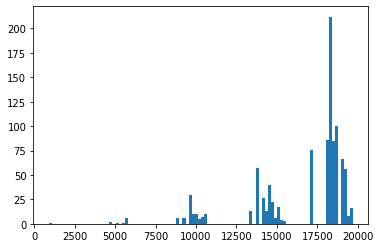

In [11]:
plt.hist(profits, bins=100)
plt.show()

We then select a value for `alpha` equal to 0.05 as the confidence level for our preferred half-width, defined by `epsilon`. We would like to get the half-width to be 0.1% of our expected profit. This then gives us the desired number of runs:

In [12]:
alpha = 0.05
z = stats.norm.ppf(1-alpha/2)
epsilon = 10e-4*np.mean(profits)
n = int(np.ceil((z*sigma/epsilon)**2))

print(f"Mean profit: {np.mean(profits)} | Half-width (epsilon): {epsilon} | Number of runs (n): {n}")

Mean profit: 16703.07856996896 | Half-width (epsilon): 16.70307856996896 | Number of runs (n): 124


We can also see this in some plots. Our preferred half-width (somewhere around 17, decided by the randomness of our initialisation) can be seen to correspond to a number of runs around 120 (again, dependent on random outcomes).

C:\Users\mikew\Anaconda3\envs\env_gurobi\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  


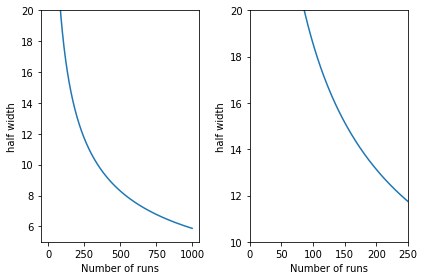

In [13]:
runs = range(1000)
half_widths = [z*sigma/math.sqrt(i) for i in runs]

plt.subplot(1, 2, 1)
plt.plot(runs, half_widths)
plt.xlabel("Number of runs")
plt.ylabel("half width")
plt.ylim(5, 20)

plt.subplot(1, 2, 2)
plt.plot(runs, half_widths)
plt.xlabel("Number of runs")
plt.ylabel("half width")
plt.xlim(0, 250)
plt.ylim(10, 20)

plt.tight_layout()
plt.show()

This means that we know our number of runs. To make sure that we have enough runs, we round the number of runs up to the nearest hundred and then find the corresponding confidence interval for the sample mean.

In [14]:
# Now find profits for this number of runs...
n_rounded = int(math.ceil(n / 100.0)) * 100
profits = calculate_profits(item_sizes, x, r, pi, num_runs=n_rounded,
                            problem_instance=problem_instance)

# and find the confidence interval
sigma = np.std(profits, ddof=1) * math.sqrt(1/n_rounded)
half_width = z*sigma/math.sqrt(n_rounded)
confidence_interval = (np.mean(profits) - half_width, np.mean(profits) + half_width)
print("Confidence interval:", confidence_interval)

Confidence interval: (16860.146633946082, 16913.5502697169)


# Stochastic Programming Models
## Part 4.

In this part, we want to formulate the SKP as a mixed integer linear programming (MILP) problem with an objective of maximising expected profit and of maximising Conditional Value at Risk (CVaR).

The model that we use is:

\begin{align*}
    \max_{x, \varepsilon_u,\eta, S_u } \; (1-\beta) \left [ \sum_{u \in U} P_u \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) \right ] + \beta \left [ \eta - \frac{1}{1-\alpha} \sum_{u \in U } P_u S_u \right ]
\end{align*}
subject to
\begin{align*}
    \begin{aligned}
        x_i & \in \{0,1\} & \quad & \text{ for all } i \in I \\
        \varepsilon_u & \geq 0 & \quad & \text{ for all } u \in U \\
        \varepsilon_u & \geq \sum_{i=1} ^{10} w_{iu} x_i - K  & \quad &  \text{ for all } u \in U \\
        S_u & \geq 0 & \quad & \text{ for all } u \in U \\
        S_u & \geq \eta - \left ( \sum_{i=1}^{10} r_i w_{iu} x_i - p \varepsilon_u \right ) & \quad & \text{ for all } u \in U.
\end{aligned}
\end{align*}

Maximising expected profit corresponds to an objective function with $\beta = 0$ and maximising Conditional Value at Risk (CVaR) means that $\beta = 1$ in the objective function. First of all, we need to create all possible scenarios in means of item weights. Since we have 10 items and 2 options for weights for each item, this means that we will have $2^{10} = 1024$ scenarios. These are created in `create_scenarios()`. We also create the function for the scenario weights for the Sample Average Approximation (SAA), seeing as the only difference is how the scenarios and the corresponding probabilities are created. This will also be done in the function `optimise_skp()` already.

In [29]:
def create_scenarios(problem_instance):
    # Create all possible permutations of 0 and 1
    binary_scenarios = [list(i) for i in itertools.product([0, 1], repeat=num_items)]
    
    # We will, without loss of generality, define that a 1 in binary_scenarios corresponds with a
    # high weight and 0 corresponds with a low weight
    scenario_weights = [[item_sizes[problem_instance]['dh'][i] if scenario[i] == 1
                         else item_sizes[problem_instance]['dl'][i]
                         for i in range(num_items)]
                        for scenario in binary_scenarios]
    scenario_probabilities = [np.prod([pi[i] if scenario[i] == 1 else (1-pi[i])
                                       for i in range(num_items)])
                              for scenario in binary_scenarios]

    return scenario_weights, scenario_probabilities

In [16]:
def create_SAA_weights(item_sizes, pi, problem_instance, N):
    scenarios_SAA = [generate_weights(item_sizes, pi, problem_instance) for j in range(N)]

    return scenarios_SAA

## Model formulation using the Gurobi library
We are now ready to formulate the linear programming model mentioned above in Gurobi. The entire model is implemented in `optimise_skp()`. Recall that we also implement the SAA model here as well, seeing as the generation of the instances is the only difference.

In [30]:
def optimise_skp(problem_instance, beta, alpha, r, p, K, scenario_weights=None,
                 scenario_probabilities=None, SAA=False, N=None, verbose=False):

    # Generate scenarios for problem instance if not provided
    if SAA:
        assert N is not None, "For SAA = True, N should be specified"

        if scenario_weights is None:
            scenario_weights = create_SAA_weights(item_sizes, pi, problem_instance, N)

        scenario_probabilities = [1/N for j in range(N)]
    else:
        assert ((scenario_weights is None) and (scenario_probabilities is None)) or \
            ((scenario_weights is not None) and (scenario_probabilities is not None)),\
            "scenario_weights and scenario_probabilities should both be given or should both be None"

        if (scenario_weights is None) and (scenario_probabilities is None):
            scenario_weights, scenario_probabilities = create_scenarios(problem_instance)

    # Initialise input parameters
    num_items = len(r)
    items = range(num_items)
    scenarios = range(len(scenario_probabilities))

    if beta == 0:
        alpha = alpha["EV"]
    else:
        alpha = alpha["CVaR"]

    # Create empty model
    m = gb.Model()
    
    if not verbose:
        # Suppress running output
        m.setParam('OutputFlag', 0)

    # Create variables
    x = m.addVars(items, vtype=gb.GRB.BINARY, name="x")
    eta = m.addVars(1, vtype=gb.GRB.CONTINUOUS, name="eta")
    epsilon = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="epsilon", lb=0)
    s = m.addVars(scenarios, vtype=gb.GRB.CONTINUOUS, name="s", lb=0)

    # Set objective function
    def scenario_profit(scenario):
        return gb.quicksum(r[item]*scenario_weights[scenario][item]*x[item]-p*epsilon[scenario]
                           for item in items)

    # obj_1 corresponds to the expected profit part of the objective, while obj_2 corresponds to the
    # CVaR part
    obj_1 = (1-beta)*gb.quicksum(scenario_probabilities[scenario]*scenario_profit(scenario)
                                 for scenario in scenarios)
    obj_2 = beta*(eta[0]-(1/(1-alpha))*gb.quicksum(scenario_probabilities[scenario]*s[scenario]
                                                   for scenario in scenarios))

    m.setObjective(obj_1 + obj_2, gb.GRB.MAXIMIZE)

    # Set constraints
    for scenario in scenarios:
        m.addConstr(epsilon[scenario] >= gb.quicksum(scenario_weights[scenario][item]*x[item]
                                                     for item in items) - K,
                    name="epsilon_constraint")
        m.addConstr(s[scenario] >= eta[0] - scenario_profit(scenario), name="S_constraint")

    # Solve model
    m.optimize()

    return m

## Part 5.
We now want to solve the EV and CVaR models optimally for 10 random instances created in Part 1 using the model we implemented in `optimise_skp()`. In total, the model will therefore be run $2 \times 10 = 20$ times, given that we have 10 instances and two models (EV and CVaR).

In [18]:
solution_EV = [optimise_skp(instance, beta_model["EV"], alpha_model, r, p, K)
               for instance in range(num_instances)]
solution_CVaR = [optimise_skp(instance, beta_model["CVaR"], alpha_model, r, p, K)
                 for instance in range(num_instances)]

Academic license - for non-commercial use only


After having run the models, we print the results below for all 10 instances.

In [19]:
# Print the results
for j in range(num_instances):
    v_EV = solution_EV[j].getVars()
    v_CVaR = solution_CVaR[j].getVars()

    # Get the values for x and eta in the optimal solutions. For EV, note that eta is always 0, so
    # we do not display it.
    outcome_x_EV = [int(v_EV[i].x) for i in range(len(v_EV))
                    if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]
    outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                      if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
    outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                        if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")][0]

    print("Results for instance", j+1)
    print("EV Model")
    print("Maximum objective value:", solution_EV[j].objVal)
    print("x:", outcome_x_EV)
    print("")
    print("CVar Model")
    print("Maximum objective value:", solution_CVaR[j].objVal)
    print("x:", outcome_x_CVaR)
    print("eta:", outcome_eta_CVaR)
    print("----------")

Results for instance 1
EV Model
Maximum objective value: 14629.374682536607
x: [0, 0, 0, 1, 0, 0, 0, 1, 1, 1]

CVar Model
Maximum objective value: 9689.949901109063
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
eta: 11661
----------
Results for instance 2
EV Model
Maximum objective value: 15339.808183792346
x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

CVar Model
Maximum objective value: 10031.358582811823
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
eta: 12107
----------
Results for instance 3
EV Model
Maximum objective value: 15039.997476211218
x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

CVar Model
Maximum objective value: 9769.45455698534
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
eta: 11899
----------
Results for instance 4
EV Model
Maximum objective value: 14310.844199467268
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]

CVar Model
Maximum objective value: 9537.581366271468
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
eta: 11531
----------
Results for instance 5
EV Model
Maximum objective value: 14983.208156931087
x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1]

CVar 

## Part 6. 

In [20]:
# TODO: give these better names, don't overwrite
B = K
U = p
a = 0.95
alpha_model = {"CVaR": a}
profits = np.zeros(10)
alphaarr = np.zeros(10)

for i in range(10):

    # Solve CVaR mode
    model_solves_CVaR = [optimise_skp(instance, beta_model["CVaR"], alpha_model, r, U, B)
                         for instance in range(num_instances)]

    # TODO: only run for one instance
    v_CVaR = model_solves_CVaR[0].getVars()

    outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                      if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
    outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                        if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
    outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                            if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
    outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                      if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

    print("Result for instance", 1)
    print("Maximum objective value: ", model_solves_CVaR[0].objVal)
    print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
    print("")

    profits[i] = model_solves_CVaR[0].Objval
    alphaarr[i] = a

a -= .05
alpha_model = {"CVaR": a}
print(profits)
print(alphaarr)

y = profits
x = alphaarr

plt.plot(x, y)

plt.xlabel('alpha')
# naming the y axis
plt.ylabel('CVaR')

# giving a title to my graph
plt.title('Change in CVaR as alpha decreases')
plt.xlim(0.95, 0.5)
# function to show the plot
plt.show()
alpha_model = {"CVaR": 0.95}


SyntaxError: invalid syntax (<ipython-input-20-98b349c2659b>, line 33)

In [ ]:
B = 400+4*g
U = math.floor(60 + 0.1 * g)
alpha = 0.95
profits = np.zeros(30)
backsize = np.zeros(30)
for i in range(30):

    # Solve CVaR mode
    model_solves_CVaR = [optimise_skp(instance, beta_model["CVaR"], alpha_model, r, U, B)
                         for instance in range(num_instances)]

    try:
        for j in range(1):
            v_CVaR = model_solves_CVaR[j].getVars()

            outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                              if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
            outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                                if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
            outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                                    if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
            outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                              if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

            print("Result for instance", j+1)
            print("Maximum objective value: ", model_solves_CVaR[j].Objval)
            print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
            print("")

            profits[i] = model_solves_CVaR[j].Objval
            backsize[i] = B
    except TypeError:
        v_CVaR = model_solves_CVaR.getVars()

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                          if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                            if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                                if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                          if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

        print("Maximum objective value: ", model_solves_CVaR.Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print(statistics.mean(outcome_x_CVaR))

    B += 12
print(profits)
print(backsize)

y = profits
x = backsize

plt.plot(x, y, linestyle='none', marker='o')

plt.xlabel('knapsack size')
# naming the y axis
plt.ylabel('CVaR')

# giving a title to my graph
plt.title('Change in CVaR as knapsack size increases')

# function to show the plot
plt.show()


In [ ]:
B = 400+4*g
U = math.floor(60 + 0.1 * g)
alpha = 0.95
profits = np.zeros(10)
penalty = np.zeros(10)
for i in range(10):

    # Solve CVaR mode
    model_solves_CVaR = [optimise_skp(instance, beta_model["CVaR"], alpha_model, r, U, B)
                         for instance in range(num_instances)]
    
    for j in range(1):
        v_CVaR = model_solves_CVaR[j].getVars()

        outcome_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                          if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        outcome_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                            if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")]
        outcome_epsilon_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                                if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "epsilon")]
        outcome_s_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                          if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "s")]

        print("Result for instance", j+1)
        print("Maximum objective value: ", model_solves_CVaR[j].Objval)
        print("CVar | x:", outcome_x_CVaR, "| eta:", outcome_eta_CVaR)
        print("")

        profits[i] = model_solves_CVaR[j].Objval
        penalty[i] = U

    U -= 5
print(profits)
print(penalty)

y = profits
x = penalty

plt.plot(x, y)

plt.xlabel('penalty')
# naming the y axis
plt.ylabel('CVaR')

# giving a title to my graph
plt.title('Change in CVaR as penalty decreases')
plt.xlim(60, 15)
# function to show the plot
plt.show()


# Sample Average Approximation
## Part 7.

The Sample Average Approximation (SAA) model is given by:
\begin{align*}
    \max_{x, \varepsilon_u, \eta, S_u} \; (1-\beta)\left[\frac{1}{N} \sum_{u=1}^N \left ( \sum_{i=1}^{10} r_i W^{u}_i x_i - p \varepsilon_u \right)\right] + \beta\left[\eta - \frac{1}{(1-\alpha)N} \sum_{u=1 }^N S_u \right] \tag{SAA}
    \end{align*}
subject to 
    \begin{align*}
    \begin{aligned}
     x_i & \in \{0,1\} & \quad & \text{ for all } i \in I \\
     \varepsilon_u & \geq 0 & \quad & \text{ for all } u \in U \\
    \varepsilon_u & \geq \sum_{i=1} ^{10} W^{u}_i x_i - K  & \quad &  \text{ for all } u \in U \\
    S_u & \geq 0 & \quad & \text{ for all } u \in U \\
    S_u & \geq \eta - \left ( \sum_{i=1}^{10} r_i W^{u}_i x_i - p \varepsilon_u \right ) & \quad & \text{ for all } u \in U.
    \end{aligned}
\end{align*}

For the first problem instance, we want to solve the SAA model $M$ times given a sample of size $N$ to obtain the SAA solution, which is the solution corresponding to the maximum out of $M$ optimal values. A relatively small number for $M$ is usually fine, we take $M = 10$. A larger number for $N$ can be taken. We take $N = 1000$ in the interest of running time, but a larger value for $N$ could be chosen.

In [21]:
N = 1000
M = 10
problem_instance = 0

SAA_solution_EV = [optimise_skp(problem_instance, beta_model["EV"], alpha_model, r, p, K,
                                SAA=True, N=N) for j in range(M)]
SAA_solution_CVaR = [optimise_skp(problem_instance, beta_model["CVaR"], alpha_model, r, p, K,
                                  SAA=True, N=N) for j in range(M)]

We can now find the optimal solution by iterating over all $M$ runs and retaining the best solution for both the EV and CVaR model.

In [22]:
SAA_objective_values_EV = []
SAA_objective_values_CVaR = []
maximum_objective_EV = 0
maximum_objective_CVaR = 0

for j in range(M):
    # EV
    SAA_objective_values_EV.append(SAA_solution_EV[j].objVal)

    if(SAA_solution_EV[j].objVal > maximum_objective_EV):
        maximum_objective_EV = SAA_solution_EV[j].objVal
        v_EV = SAA_solution_EV[j].getVars()
        SAA_x_EV = [int(v_EV[i].x) for i in range(len(v_EV))
                    if (re.sub("\[\d+\]", "", v_EV[i].varName) == "x")]

    # CVaR
    SAA_objective_values_CVaR.append(SAA_solution_CVaR[j].objVal)

    if(SAA_solution_CVaR[j].objVal > maximum_objective_CVaR):
        maximum_objective_CVaR = SAA_solution_CVaR[j].objVal
        v_CVaR = SAA_solution_CVaR[j].getVars()
        SAA_x_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                      if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "x")]
        SAA_eta_CVaR = [int(v_CVaR[i].x) for i in range(len(v_CVaR))
                        if (re.sub("\[\d+\]", "", v_CVaR[i].varName) == "eta")][0]
        
print("EV Model")
print("Maximum objective value:", maximum_objective_EV)
print("x:", SAA_x_EV)
print("")
print("CVaR Model")
print("Maximum objective value:", maximum_objective_CVaR)
print("x:", SAA_x_CVaR)
print("eta:", SAA_eta_CVaR)

EV Model
Maximum objective value: 14708.936063947607
x: [0, 0, 0, 1, 0, 0, 0, 1, 1, 1]

CVaR Model
Maximum objective value: 10185.557585454682
x: [0, 0, 0, 0, 0, 0, 1, 1, 1, 1]
eta: 11661


## Derivation of optimality gap
The optimality gap is defined by: 
\begin{align*}
    \mathrm{gap}(\hat{x}) =  v^* - g(\hat{x}),
\end{align*}
    
An upper bound for $v^*$ is found using $E(\hat{v}_N)$. For this we need the sample mean of $E(\hat{v}_N)$:
\begin{align*}
    \bar{v}_{N,M} = \frac{1}{M} \sum_{j = 1}^M \hat{v}^j_N
\end{align*}
    
and the sample variance: 
\begin{align*}
    \hat{\sigma}^2_{N,M} = \frac{1}{M(M-1)} \sum_{j =1}^M \left(\hat{v}^j_N - \bar{v}_{N,M}\right)^2.
\end{align*}

In [23]:
# Sample mean
sample_mean_UB_EV = np.mean(SAA_objective_values_EV)
sample_mean_UB_CVaR = np.mean(SAA_objective_values_CVaR)

# Sample standard deviation
sample_std_UB_EV = np.std(SAA_objective_values_EV, ddof=1) * math.sqrt(1/M)
sample_std_UB_CVaR = np.std(SAA_objective_values_CVaR, ddof=1) * math.sqrt(1/M)

print("EV Model")
print(f"Sample mean: {sample_mean_UB_EV}")
print(f"Standard deviation of sample mean: {sample_std_UB_EV}")
print("")
print("CVaR Model")
print(f"Sample mean: {sample_mean_UB_CVaR}")
print(f"Standard deviation of sample mean: {sample_std_UB_CVaR}")

EV Model
Sample mean: 14620.615853797985
Standard deviation of sample mean: 18.719040638778658

CVaR Model
Sample mean: 9736.300306804356
Standard deviation of sample mean: 125.47468936280656


A 95% upper bound for $v^*$ is then given by:
$$
\begin{align*}
    U_{N,M} = \bar{v}_{N,M} + t_{\gamma,\nu}\hat{\sigma}_{N,M},
\end{align*}
$$
where $\nu = M-1$ and $t_{\gamma,\nu}$ is the $\gamma$-critical value of the $t$-distribution with $\nu$ degrees of freedom.

In [24]:
nu = M-1
gamma = 0.05
critical_value_t = stats.t.ppf(1-gamma, nu)

gap_UB_EV = sample_mean_UB_EV + critical_value_t*sample_std_UB_EV
gap_UB_CVaR = sample_mean_UB_CVaR + critical_value_t*sample_std_UB_CVaR

print(f"{100*(1-gamma)}% upper bound (EV model): {gap_UB_EV}")
print(f"{100*(1-gamma)}% upper bound (CVaR model): {gap_UB_CVaR}")

95.0% upper bound (EV model): 14654.9299692798
95.0% upper bound (CVaR model): 9966.309582596014


For the lower bound for $g(\hat{x})$, we first need to generate a random sample $W^1, W^2, \dots, W^{N'}$, where $N'$ is some large number. The calculations are quite quick as they only concern function evaluations, so we are free to take a relatively large number. We take $N' = 10^5$.

In [25]:
N_prime = 10000
scenario_weights_SAA = create_SAA_weights(item_sizes, pi, problem_instance, N_prime)

Then, we compute the sample mean $\hat{g}_{N'}(\hat{x})$ and its sample variance.

Let 
$$
\begin{align*}
    Q(\hat{x},W^{u}) = (1-\beta) \left(\sum_{i=1}^{10} r_i W^{u}_i \hat{x}_i - p \varepsilon_u \right) + \beta \left[\eta - \frac{1}{1-\alpha} S_u \right],
\end{align*}
$$
where $\varepsilon_u = \max \left\{0, \sum_{i=1} ^{10} W^{u}_i \hat{x}_i - K \right\}$ and $S_u = \max \left\{0,\eta - \left(\sum_{i=1}^{10} r_i W^{u}_i \hat{x}_i - p \varepsilon_u \right) \right\}$ for all $u \in U$. This function is coded in `scenario_profit_given_x_hat`.

Then, the sample average is given by
$$
\begin{align*}
    \hat{g}_{N'}(\hat{x}) = \frac{1}{N'} \sum_{u=1 }^{N'}  Q(\hat{x},W^{u}),
\end{align*}
$$
and the sample variance of $\hat{g}_{N'}(\hat{x})$ is given by
$$
\begin{align*}
    \hat{\sigma}^2_{N'}(\hat{x}) = \frac{1}{N'(N'-1)} \sum_{u=1}^{N'} \left[Q(\hat{x},W^{u}) - \hat{g}_{N'}(\hat{x}) \right]^2.
\end{align*}
$$.

In [26]:
def scenario_profit_given_x_hat(x, alpha, beta, r, p, K, eta, scenario_weight):
    
    scenario_excess = max(0, sum(scenario_weight*x) - K)
    profit_EV = sum(r*scenario_weight*x) - p*scenario_excess   
    profit_CVaR = eta-(1/(1-alpha))*max(0, eta-profit_EV)
    
    Q = (1-beta)*profit_EV + beta*profit_CVaR
    
    return Q

In [27]:
LB_scenarios = range(len(scenario_weights_SAA))

Q_EV = [scenario_profit_given_x_hat(SAA_x_EV, alpha_model["EV"], beta_model["EV"], r, p, K,
                                    SAA_eta_CVaR, scenario_weights_SAA[scenario])
        for scenario in LB_scenarios]
Q_CVaR = [scenario_profit_given_x_hat(SAA_x_CVaR, alpha_model["CVaR"], beta_model["CVaR"], r, p, K,
                                      SAA_eta_CVaR, scenario_weights_SAA[scenario])
          for scenario in LB_scenarios]

In [28]:
# Sample mean
sample_mean_LB_EV = np.mean(Q_EV)
sample_mean_LB_CVaR = np.mean(Q_CVaR)

# Sample standard deviation
sample_std_LB_EV = np.std(Q_EV, ddof=1) * math.sqrt(1/N_prime)
sample_std_LB_CVaR = np.std(Q_CVaR, ddof=1) * math.sqrt(1/N_prime)

print("EV Model")
print(f"Sample mean: {sample_mean_LB_EV}")
print(f"Standard deviation of sample mean: {sample_std_LB_EV}")
print("")
print("CVaR Model")
print(f"Sample mean: {sample_mean_LB_CVaR}")
print(f"Standard deviation of sample mean: {sample_std_LB_CVaR}")

EV Model
Sample mean: 14609.960450480083
Standard deviation of sample mean: 26.376770314491782

CVaR Model
Sample mean: 9713.84961756664
Standard deviation of sample mean: 119.77388120678549


A 95% lower bound for $g(\hat{x})$ is then given by:
$$
\begin{align*}
    L_{N'} = \hat{g}_{N'}(\hat{x}) - z_{\gamma} \hat{\sigma}_{N'}(\hat{x}),
\end{align*}
$$
where $z_{\gamma}$ is the $\gamma$-critical value of the standard normal distribution.

In [29]:
critical_value_z = stats.norm.ppf(1-gamma,0,1)
gap_LB_EV = sample_mean_LB_EV - critical_value_z*sample_std_LB_EV
gap_LB_CVaR = sample_mean_LB_CVaR - critical_value_z*sample_std_LB_CVaR

print(f"{100*(1-gamma)}% lower bound (EV model): {gap_LB_EV}")
print(f"{100*(1-gamma)}% lower bound (CVaR model): {gap_LB_CVaR}")

95.0% lower bound (EV model): 14566.574524161026
95.0% lower bound (CVaR model): 9516.839114649605


This gives us a total 90% confidence bound on the true $\mathrm{gap}(\hat{x})$:
$$
\begin{align*}
    \widehat{gap}(\hat{x}) = U_{N,M} - L_{N'}.
\end{align*}
$$

In [30]:
gap_EV = gap_UB_EV - gap_LB_EV
gap_CVaR = gap_UB_CVaR - gap_LB_CVaR

print(f"{100*(1-2*gamma)}% confidence bound on true gap (EV model): {gap_EV}")
print(f"{100*(1-2*gamma)}% confidence bound on true gap (CVaR model): {gap_CVaR}")

90.0% confidence bound on true gap (EV model): 88.35544511877379
90.0% confidence bound on true gap (CVaR model): 449.47046794640846


# Bonus question
We now research how antithetic variates can be adopted within the SAA scheme. We start by generating two random sample batches of the weights $W^1, \dots, W^N$ using $U$ and $1-U$, where $U \sim Unif(0,1)$ of size $N$. This is done in `create_SAA_weights_AV()`, using `generate_weights_AV()`.

In [31]:
def generate_weights_AV(pi, item_sizes, problem_instance):
    
    num_items = len(pi)
    
    U = np.random.uniform(size=num_items)
    W1 = [item_sizes[problem_instance]["dh"][i] if U[i] < pi[i]
          else item_sizes[problem_instance]["dl"][i] for i in range(num_items)]
    W1 = np.asarray(W1)

    U_anti = 1-U
    W2 = [item_sizes[problem_instance]["dh"][i] if U_anti[i] < pi[i]
          else item_sizes[problem_instance]["dl"][i] for i in range(num_items)]
    W2 = np.asarray(W2)

    weights_AV = (W1, W2)
    
    return weights_AV

In [32]:
def create_SAA_weights_AV(pi, item_sizes, problem_instance, N):

    scenarios_SAA_AV_1 = []
    scenarios_SAA_AV_2 = []

    for j in range(N):
        W = generate_weights_AV(pi, item_sizes, problem_instance)
        scenarios_SAA_AV_1.append(W[0])
        scenarios_SAA_AV_2.append(W[1])
        
    scenarios_SAA_AV = (scenarios_SAA_AV_1, scenarios_SAA_AV_2)
    
    return scenarios_SAA_AV

We now solve the SAA scheme $M$ times again, but now for the antithetic variates. We get pairs of antithetic variates $(\hat{v}^{1,1}_N,\hat{v}^{1,2}_N), (\hat{v}^{2,1}_N,\hat{v}^{2,2}_N), \dots, (\hat{v}^{M,1}_N,\hat{v}^{M,2}_N)$ and then determine $\hat{v}^{j}_N = \frac{1}{2}\left(\hat{v}^{j,1}_N+\hat{v}^{j,2}_N\right)$ for all $j=1,\dots,M$ and get the SAA solution $\hat{x}$ in a similar sense as described before.

Since we now have the antithetic variates, we take $M$ and $N'$ half as large as before.

In [33]:
M //= 2

SAA_solution_EV_AV = []
SAA_solution_CVaR_AV = []
SAA_EV_max_objective = 0
SAA_CVaR_max_objective = 0

for j in range(M):
    # Solve EV model
    scenario_weights_AV = create_SAA_weights_AV(pi, item_sizes, problem_instance, N)

    sol1 = optimise_skp(problem_instance, beta_model["EV"], alpha_model, r, p, K,
                        scenario_weights=scenario_weights_AV[0], scenario_probabilities=None,
                        SAA=True, N=N)
    sol2 = optimise_skp(problem_instance, beta_model["EV"], alpha_model, r, p, K,
                        scenario_weights=scenario_weights_AV[1], scenario_probabilities=None,
                        SAA=True, N=N)

    if(sol1.objVal > SAA_EV_max_objective):
        SAA_EV_max_objective = sol1.objVal
        EV_AV = sol1.getVars()
        SAA_x_EV_AV = [int(EV_AV[i].x) for i in range(len(EV_AV))
                       if (re.sub("\[\d+\]", "", EV_AV[i].varName) == "x")]

    if(sol2.objVal > SAA_EV_max_objective):
        SAA_EV_max_objective = sol2.objVal
        EV_AV = sol2.getVars()
        SAA_x_EV_AV = [int(EV_AV[i].x) for i in range(len(EV_AV))
                       if (re.sub("\[\d+\]", "", EV_AV[i].varName) == "x")]

    SAA_solution_EV_AV.append((sol1.objVal+sol2.objVal)/2)

    # Solve CVaR model
    scenario_weights_AV = create_SAA_weights_AV(pi, item_sizes, problem_instance, N)

    sol1 = optimise_skp(problem_instance, beta_model["CVaR"], alpha_model, r, p, K,
                               scenario_weights=scenario_weights_AV[0], scenario_probabilities=None,
                               SAA=True, N=N)
    sol2 = optimise_skp(problem_instance, beta_model["CVaR"], alpha_model, r, p, K,
                               scenario_weights=scenario_weights_AV[1], scenario_probabilities=None,
                               SAA=True, N=N)

    if(sol1.objVal > SAA_CVaR_max_objective):
        SAA_CVaR_max_objective = sol1.objVal
        CVaR_AV = sol1.getVars()
        SAA_x_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV))
                         if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "x")]
        SAA_eta_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV))
                           if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "eta")][0]

    if(sol2.objVal > SAA_CVaR_max_objective):
        SAA_CVaR_max_objective = sol2.objVal
        CVaR_AV = sol2.getVars()
        SAA_x_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV))
                         if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "x")]
        SAA_eta_CVaR_AV = [int(CVaR_AV[i].x) for i in range(len(CVaR_AV))
                           if (re.sub("\[\d+\]", "", CVaR_AV[i].varName) == "eta")][0]

    SAA_solution_CVaR_AV.append((sol1.objVal+sol2.objVal)/2)

In [34]:
# Sample mean
sample_mean_UB_EV_AV = np.mean(SAA_solution_EV_AV)
sample_mean_UB_CVaR_AV = np.mean(SAA_solution_CVaR_AV)

# Sample standard deviation
sample_std_UB_EV_AV = np.std(SAA_solution_EV_AV, ddof=1) * math.sqrt(1/M)
sample_std_UB_CVaR_AV = np.std(SAA_solution_CVaR_AV, ddof=1) * math.sqrt(1/M)

# SAA solution EV model
print("EV model: ")
print("x:", SAA_x_EV_AV)
print("Maximum objective value:", SAA_EV_max_objective)
print("")
print("Sample mean with AV: ", sample_mean_UB_EV_AV)
print("Standard deviation of sample mean with AV: ", sample_std_UB_EV_AV)
print("")
print("Sample mean without AV: ", sample_mean_UB_EV)
print("Standard deviation of sample mean without AV: ", sample_std_UB_EV)
print("--------------------")
print("CVaR model: ")
print("x:", SAA_x_CVaR_AV)
print("eta:", SAA_eta_CVaR_AV)
print("Maximum objective value:", SAA_CVaR_max_objective)
print("")
print("Sample mean with AV: ", sample_mean_UB_CVaR_AV)
print("Standard deviation of sample mean with AV: ", sample_std_UB_CVaR_AV)
print("")
print("Sample mean without AV: ", sample_mean_UB_CVaR)
print("Standard deviation of sample mean without AV: ", sample_std_UB_CVaR)

EV model: 
x: [0, 0, 0, 1, 0, 0, 0, 1, 1, 1]
Maximum objective value: 14704.086510998064

Sample mean with AV:  14643.216077369256
Standard deviation of sample mean with AV:  11.588871611596696

Sample mean without AV:  14620.615853797985
Standard deviation of sample mean without AV:  18.719040638778658
--------------------
CVaR model: 
x: [0, 0, 0, 0, 0, 1, 0, 1, 1, 1]
eta: 11832
Maximum objective value: 10183.918190350096

Sample mean with AV:  9600.131876382391
Standard deviation of sample mean with AV:  105.07925752606984

Sample mean without AV:  9736.300306804356
Standard deviation of sample mean without AV:  125.47468936280656


We now repeat the process and generate two random sample batches of the weights $W^1,\dots,W^{N'}$ using $U$ and $1-U$ and obtain $Q_1\left(\hat{x},W^1\right), \dots, Q_1\left(\hat{x},W^{N'}\right)$ and $Q_2\left(\hat{x},W^1\right), \dots, Q_2\left(\hat{x},W^{N'}\right)$. Then, we compute $Q\left(\hat{x},W^u\right) = \frac{1}{2}\left(Q_1\left(\hat{x},W^u\right) + Q_2\left(\hat{x},W^u\right)\right)$ for all $u = 1, \dots, N'$.

In [35]:
N_prime //= 2
scenario_weights_SAA_AV = create_SAA_weights_AV(pi, item_sizes, problem_instance, N_prime)

LB_scenarios_AV = range(len(scenario_weights_SAA_AV[0]))

# Find Q for EV Model
Q_EV_AV_1 = [scenario_profit_given_x_hat(SAA_x_EV_AV, alpha_model["EV"], beta_model["EV"], r, p, K,
                                         SAA_eta_CVaR_AV, scenario_weights_SAA_AV[0][scenario])
             for scenario in LB_scenarios_AV]
Q_EV_AV_2 = [scenario_profit_given_x_hat(SAA_x_EV_AV, alpha_model["EV"], beta_model["EV"], r, p, K,
                                         SAA_eta_CVaR_AV, scenario_weights_SAA_AV[1][scenario])
             for scenario in LB_scenarios_AV]
Q_EV_AV = (np.array(Q_EV_AV_1) + np.array(Q_EV_AV_2)) / 2

# Find Q for CVaR Model
Q_CVaR_AV_1 = [scenario_profit_given_x_hat(SAA_x_CVaR_AV, 0.95, beta_model["CVaR"], r, p, K,
                                           SAA_eta_CVaR_AV, scenario_weights_SAA_AV[0][scenario])
               for scenario in LB_scenarios_AV]
Q_CVaR_AV_2 = [scenario_profit_given_x_hat(SAA_x_CVaR_AV, 0.95, beta_model["CVaR"], r, p, K,
                                           SAA_eta_CVaR_AV, scenario_weights_SAA_AV[1][scenario])
               for scenario in LB_scenarios_AV]
Q_CVaR_AV = (np.array(Q_CVaR_AV_1) + np.array(Q_CVaR_AV_2)) / 2

In [36]:
# Sample mean
sample_mean_LB_EV_AV = np.mean(Q_EV_AV)
sample_mean_LB_CVaR_AV = np.mean(Q_CVaR_AV)

# Sample standard deviation
sample_std_LB_EV_AV = np.std(Q_EV_AV, ddof=1) * math.sqrt(1/N_prime)
sample_std_LB_CVaR_AV = np.std(Q_CVaR_AV, ddof=1) * math.sqrt(1/N_prime)

print("EV Model")
print("Sample mean with AV:", sample_mean_LB_EV_AV)
print("Standard deviation of sample mean with AV:", sample_std_LB_EV_AV)
print("")
print("Sample mean without AV:", sample_mean_LB_EV)
print("Standard deviation of sample mean without AV:", sample_std_LB_EV)
print("--------------------")
print("CVaR Model")
print("Sample mean with AV:", sample_mean_LB_CVaR_AV)
print("Standard deviation of sample mean with AV:", sample_std_LB_CVaR_AV)
print("")
print("Sample mean without AV:", sample_mean_LB_CVaR)
print("Standard deviation of sample mean without AV:", sample_std_LB_CVaR)

EV Model
Sample mean with AV: 14650.620805837918
Standard deviation of sample mean with AV: 21.632271088393786

Sample mean without AV: 14609.960450480083
Standard deviation of sample mean without AV: 26.376770314491782
--------------------
CVaR Model
Sample mean with AV: 9269.389543083915
Standard deviation of sample mean with AV: 136.96000022320794

Sample mean without AV: 9713.84961756664
Standard deviation of sample mean without AV: 119.77388120678549


Lastly, we determine a $90\%$ confidence bound on the true $\mathrm{gap}(\hat{x})$ using antithetic variates. The gap is given by
$$
\begin{align*}
    \widehat{gap}(\hat{x}) = U_{N,M} - L_{N'},
\end{align*}
$$
with the upper and lower bounds defined similarly as before.

In [37]:
nu = M-1
gamma = 0.05

# Upper bound
critical_value_t_AV = stats.t.ppf(1-gamma,nu)
gap_UB_EV_AV = sample_mean_UB_EV_AV + critical_value_t_AV*sample_std_UB_EV_AV
gap_UB_CVaR_AV = sample_mean_UB_CVaR_AV + critical_value_t*sample_std_UB_CVaR_AV

# Lower bound
critical_value_z_AV = stats.norm.ppf(1-gamma,0,1)
gap_LB_EV_AV = sample_mean_LB_EV_AV - critical_value_z_AV*sample_std_LB_EV_AV
gap_LB_CVaR_AV = sample_mean_LB_CVaR_AV - critical_value_z*sample_std_LB_CVaR_AV

# Gap 
gap_EV_AV = gap_UB_EV_AV - gap_LB_EV_AV
gap_CVaR_AV = gap_UB_CVaR_AV - gap_LB_CVaR_AV

print(f"{100*(1-2*gamma)}% confidence bound on true gap (EV model) without AV: {gap_EV}")
print(f"{100*(1-2*gamma)}% confidence bound on true gap (EV model) with AV: {gap_EV_AV}")
print("")
print(f"{100*(1-2*gamma)}% confidence bound on true gap (CVaR model) with AV: {gap_CVaR}")
print(f"{100*(1-2*gamma)}% confidence bound on true gap (CVaR model) with AV: {gap_CVaR_AV}")

90.0% confidence bound on true gap (EV model) without AV: 88.35544511877379
90.0% confidence bound on true gap (EV model) with AV: 52.8828897347812

90.0% confidence bound on true gap (CVaR model) with AV: 449.47046794640846
90.0% confidence bound on true gap (CVaR model) with AV: 748.6436323375747
